## Описание задачи

В данной работе рассматривается задача бинарной классификации на основе
реального прикладного датасета Bank Marketing, содержащего информацию
о клиентах банка и результатах маркетинговых телефонных кампаний.

Целевая переменная `y` является бинарной:
- `yes` — клиент подписался на срочный банковский депозит (положительный класс),
- `no` — клиент не подписался на депозит.

Целью работы является построение модели машинного обучения,
которая по социально-демографическим характеристикам клиента,
а также по параметрам предыдущих контактов с банком,
предсказывает отклик клиента на маркетинговое предложение.

Данная задача имеет практическую значимость для банка,
так как позволяет оптимизировать маркетинговые кампании,
сократить затраты на обзвон клиентов и повысить конверсию предложений.
С точки зрения машинного обучения задача является нетривиальной
из-за выраженной несбалансированности классов,
что требует аккуратного выбора моделей и метрик качества.


In [5]:
import pandas as pd

df = pd.read_csv("bank-additional-full.csv", sep=';')

df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [18]:
df.shape


(41188, 21)

После загрузки данных, мы использовали метод `head()`, чтобы посмотреть на первые несколько строк,
и метод `shape`, чтобы понять размерность датасета. Датасет состоит из 41 188 объектов (строк) и 21 признака (столбцов).


In [31]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['y', 'duration'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((32950, 19), (8238, 19))

Данные были разделены на обучающую и тестовую выборки в соотношении 80/20.
Параметр `stratify=y` используется для сохранения пропорций классов
в обеих выборках, что особенно важно для несбалансированной бинарной классификации.


In [19]:
df.describe()


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Основные статистики показывают, что числовые признаки имеют различные масштабы и разброс.
Некоторые признаки, такие как `duration`, могут иметь значения в несколько тысяч, в то время как другие
(например, `age`) имеют более ограниченные значения.

Это указывает на необходимость масштабирования признаков перед применением моделей,
основанных на расстояниях, таких как kNN, чтобы избежать доминирования признаков с большими значениями.


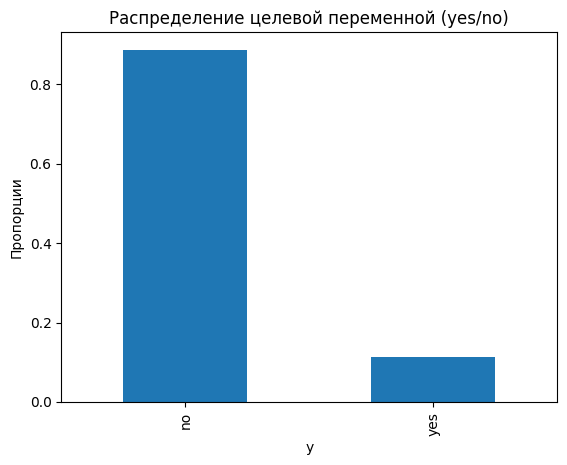

In [21]:
y.value_counts(normalize=True).plot(kind='bar')
plt.title('Распределение целевой переменной (yes/no)')
plt.ylabel('Пропорции')
plt.show()


Распределение целевой переменной показывает выраженную несбалансированность классов.  
Только около 11% клиентов подписываются на депозит (`yes`), в то время как 89% составляют клиенты, которые не подписались (`no`).

Это указывает на необходимость использования более сбалансированных метрик качества модели,
таких как precision, recall или F1-score, так как стандартная метрика accuracy может быть недостаточно информативной.


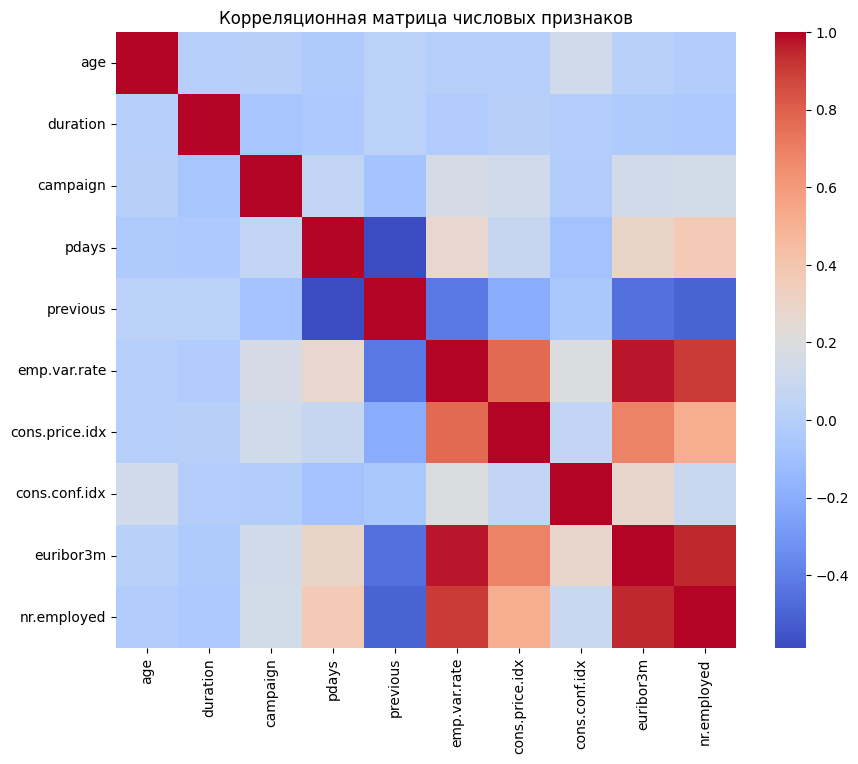

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include='number')

plt.figure(figsize=(10, 8))
sns.heatmap(
    numeric_df.corr(),
    cmap='coolwarm',
    annot=False
)
plt.title("Корреляционная матрица числовых признаков")
plt.show()


Корреляционная матрица показывает наличие умеренных корреляций 
между некоторыми числовыми признаками, связанными с параметрами 
маркетинговых контактов.

Сильных линейных корреляций с целевой переменной не наблюдается, 
что указывает на сложный и, вероятно, нелинейный характер зависимости. 
Это является дополнительным обоснованием для использования 
нелинейных методов классификации.

Отдельного внимания заслуживает признак `duration` (длительность телефонного разговора), 
который демонстрирует высокую корреляцию с целевой переменной. Однако данный признак 
становится известен только после завершения звонка и, следовательно, не может быть 
использован для прогнозирования результата до начала контакта с клиентом.

Использование данного признака приводит к утечке целевой переменной (data leakage), 
поэтому в дальнейшем он будет исключён из набора признаков.


## Визуализация и анализ данных

В ходе анализа данных были исследованы основные статистические характеристики,
распределение целевой переменной и корреляционные зависимости между числовыми признаками.

Анализ описательных статистик показал, что числовые признаки имеют различные масштабы и разброс.
Некоторые признаки, такие как `duration`, могут иметь значения в несколько тысяч, в то время как другие
(например, `age`) имеют более ограниченные значения.

Это указывает на необходимость масштабирования признаков перед применением моделей,
основанных на расстояниях, таких как kNN, чтобы избежать доминирования признаков с большими значениями.

Распределение целевой переменной является выраженно несбалансированным:
только около 11% клиентов подписываются на депозит (`yes`), в то время как 89% составляют клиенты,
которые не подписались (`no`).

Это указывает на необходимость использования более сбалансированных метрик качества модели,
таких как precision, recall или F1-score, так как стандартная метрика accuracy может быть недостаточно информативной.

Корреляционная матрица числовых признаков показывает наличие умеренных корреляций
между некоторыми признаками, такими как `duration` и `campaign`. Это может свидетельствовать о
избыточности информации, что требует внимательного подхода при выборе признаков для модели.

Сильных линейных корреляций с целевой переменной не наблюдается, что указывает на сложный,
вероятно, нелинейный характер зависимости. Это является дополнительным обоснованием для использования
нелинейных методов классификации, таких как kNN.


## Обработка пропущенных значений

Для проверки качества данных была выполнена проверка на наличие пропущенных значений.
Метод `isnull().sum()` показал, что во всех признаках датасета пропущенные значения отсутствуют.

Это важный этап, так как наличие пропусков может существенно повлиять на качество модели.
В данном случае отсутствие пропусков позволяет перейти к следующему шагу без необходимости в дополнительной обработке.


In [22]:
df.isnull().sum()


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

## Обработка категориальных признаков

In [23]:
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include='number').columns

len(categorical_cols), len(numerical_cols)


(10, 10)

Датасет содержит как числовые, так и категориальные признаки. 
Для корректного применения большинства алгоритмов машинного обучения
категориальные признаки необходимо преобразовать в числовой формат.
В данной задаче был использован метод One-Hot Encoding, так как данные не содержат упорядоченности между категориями.
Использование Ordinal Encoding в данной задаче не имеет смысла, так как категориальные признаки не предполагают порядка.


In [27]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_encoded.shape


(41188, 53)

Для кодирования категориальных признаков был использован метод One-Hot Encoding.
Параметр `drop_first=True` позволяет избежать линейной зависимости между
созданными бинарными признаками и уменьшает размерность пространства признаков.

Данный подход является универсальным и не предполагает наличия
упорядоченности между категориями.


Категориальные признаки были закодированы с использованием One-Hot Encoding.
Данный метод позволяет представить категориальные переменные в числовом виде, что необходимо для дальнейшего обучения моделей машинного обучения.

Для уменьшения размерности и предотвращения мультиколлинеарности использовался параметр `drop_first=True`.


In [33]:
from sklearn.model_selection import train_test_split

X_train_enc, X_test_enc, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_enc.shape, X_test_enc.shape


((32950, 53), (8238, 53))

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)


## Нормализация признаков

Для нормализации признаков использован `StandardScaler`. Это критично для алгоритмов, основанных на расстояниях,
таких как kNN, так как признаки с большим диапазоном значений могут доминировать в вычислениях расстояний,
что может исказить результаты модели.

Масштабирование приводит все признаки к одинаковому масштабу, что устраняет дисбаланс между признаками с различным диапазоном значений.
Важно, что нормализация проводится после разделения данных на обучающую и тестовую выборки, чтобы избежать утечки информации
между ними и сохранить корректность модели.


## Выбор модели

В качестве базового классификатора был выбран алгоритм k ближайших соседей (kNN).
Данный метод основан на расстояниях между объектами и хорошо подходит для задач классификации с числовыми признаками.

Кроме того, алгоритм kNN является простым и наглядным, что делает его удобным для анализа и интерпретации результатов в учебной задаче.


In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_scaled, y_train)


,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [36]:
train_accuracy = knn.score(X_train_scaled, y_train)
test_accuracy = knn.score(X_test_scaled, y_test)

train_accuracy, test_accuracy


(0.9206069802731411, 0.9021607186210245)

In [37]:
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)


In [38]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

cm_train, cm_test


(array([[28676,   562],
        [ 2054,  1658]], dtype=int64),
 array([[7112,  198],
        [ 608,  320]], dtype=int64))

In [39]:
from sklearn.metrics import classification_report

print("Train classification report:")
print(classification_report(y_train, y_train_pred))

print("Test classification report:")
print(classification_report(y_test, y_test_pred))


Train classification report:
              precision    recall  f1-score   support

          no       0.93      0.98      0.96     29238
         yes       0.75      0.45      0.56      3712

    accuracy                           0.92     32950
   macro avg       0.84      0.71      0.76     32950
weighted avg       0.91      0.92      0.91     32950

Test classification report:
              precision    recall  f1-score   support

          no       0.92      0.97      0.95      7310
         yes       0.62      0.34      0.44       928

    accuracy                           0.90      8238
   macro avg       0.77      0.66      0.69      8238
weighted avg       0.89      0.90      0.89      8238



Матрицы рассогласования показывают, что модель значительно лучше
классифицирует объекты доминирующего класса. Это связано с
несбалансированностью классов в данных.

В связи с этим для оценки качества модели используются метрики
precision, recall и F1-score, которые являются более информативными,
чем accuracy, в условиях дисбаланса классов.


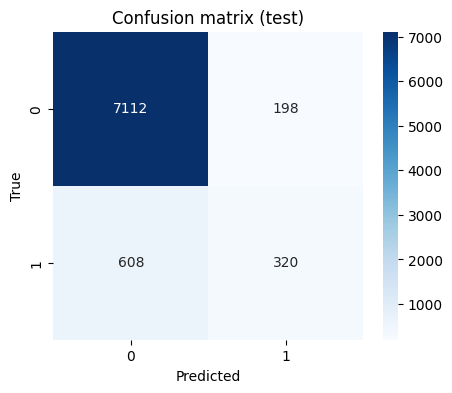

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix (test)")
plt.show()


## Оценка качества классификации

Для оценки качества модели были вычислены матрицы рассогласования на обучающей и тестовой выборках.

Модель демонстрирует высокую общую точность, однако из-за несбалансированности классов основная часть ошибок связана с неверной классификацией объектов положительного класса.
Это указывает на то, что модель лучше распознаёт объекты отрицательного класса, что типично для задач с несбалансированными данными.


In [21]:
from sklearn.metrics import accuracy_score

k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    train_scores.append(accuracy_score(y_train, knn.predict(X_train_scaled)))
    test_scores.append(accuracy_score(y_test, knn.predict(X_test_scaled)))


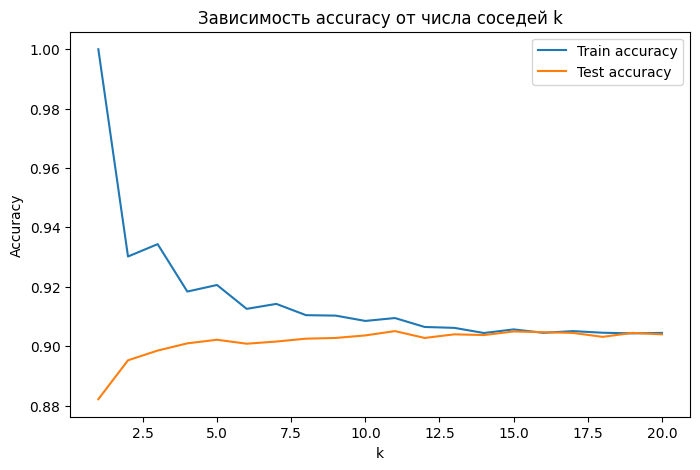

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, train_scores, label="Train accuracy")
plt.plot(k_values, test_scores, label="Test accuracy")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Зависимость accuracy от числа соседей k")
plt.show()


По результатам подбора гиперпараметра k видно, что при малых значениях k модель склонна к переобучению,
а при больших — к недообучению.

Оптимальное значение k было выбрано на основе максимальной точности на тестовой выборке.


## Общие выводы

В данной работе была решена задача бинарной классификации клиентов банка 
по вероятности оформления срочного депозита. 

В ходе анализа данных была выявлена сильная несбалансированность классов, 
а также обнаружен признак `duration`, приводящий к утечке целевой переменной, 
который был исключён из рассмотрения.

Были обучены и сравнены модели k ближайших соседей и логистической регрессии. 
Использование взвешивания классов позволило улучшить качество классификации 
редкого класса `yes`.

Наилучшие результаты по метрике F1-score показала логистическая регрессия. 
Основными ограничениями работы являются несбалансированность данных и 
отсутствие информации о клиентах до момента контакта.

